### Data Processing

In [5]:
import pandas as pd
import sqlite3

# Connect to the database file
conn = sqlite3.connect('algobetting_20250530.db')

# Read a table into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM fbref_team_shots_features_005_365", conn)

#tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
#table_names = tables['name'].tolist()
#print("Table names:", table_names)

# Close the connection
conn.close()

# Display the DataFrame
df.head()

,match_url,match_date,season,division,team,opp_team,is_home,shots,opp_shots,weighted_attack_goals,...,opp_weighted_defense_opp_goals,opp_weighted_defense_opp_shots,opp_weighted_defense_opp_shots_on_target,opp_weighted_defense_opp_xg,opp_weighted_defense_opp_npxg,opp_weighted_defense_opp_touches_att_pen_area,opp_weighted_defense_opp_touches_att_3rd,opp_weighted_defense_opp_touches,opp_weighted_defense_opp_pens_won,opp_weighted_defense_opp_corner_kicks
0,https://fbref.com/en/matches/d8efb6cc/Leiceste...,2025-04-07 00:00:00,2024-2025,Premier-League,Leicester City,Newcastle Utd,1,7.0,16.0,0.633452,...,1.455964,12.906852,4.355476,1.303009,1.251797,24.197442,155.426749,602.362132,0.065146,4.995137
1,https://fbref.com/en/matches/d8efb6cc/Leiceste...,2025-04-07 00:00:00,2024-2025,Premier-League,Newcastle Utd,Leicester City,0,16.0,7.0,1.799098,...,2.316454,16.130546,5.494694,1.887059,1.825313,31.816265,195.700380,690.196090,0.073388,6.049093
2,https://fbref.com/en/matches/53e359bb/Manchest...,2025-04-06 00:00:00,2024-2025,Premier-League,Manchester Utd,Manchester City,1,13.0,9.0,1.293545,...,1.247461,9.464969,3.624739,1.283831,1.218377,18.396063,101.868168,517.512371,0.081817,3.457143
3,https://fbref.com/en/matches/53e359bb/Manchest...,2025-04-06 00:00:00,2024-2025,Premier-League,Manchester City,Manchester Utd,0,9.0,13.0,2.000638,...,1.388690,12.012086,4.125325,1.549812,1.440821,22.861867,150.093587,588.030979,0.103199,5.190624
4,https://fbref.com/en/matches/f671e515/Tottenha...,2025-04-06 00:00:00,2024-2025,Premier-League,Tottenham,Southampton,1,12.0,12.0,1.687435,...,2.381603,17.076964,6.432989,2.281046,2.105396,32.140872,176.702024,626.645503,0.143379,5.438184


In [6]:
# Engineer interaction features
weighted_attack_cols = [col for col in df.columns if col.startswith('weighted_attack_')]

# Create new columns by multiplying weighted_attack columns with their opp_weighted_defense counterparts
for col in weighted_attack_cols:
    # Extract the suffix after 'weighted_attack_'
    suffix = col.replace('weighted_attack_', '')
    
    # Construct the corresponding opp_weighted_defense column name
    opp_col = f'opp_weighted_defense_opp_{suffix}'
    
    # Check if the corresponding opp column exists
    if opp_col in df.columns:
        # Create new column name for the product
        new_col_name = f'product_{suffix}'
        
        # Multiply the columns
        df[new_col_name] = df[col] * df[opp_col]
        print(f"Created: {new_col_name} = {col} * {opp_col}")
    else:
        print(f"Warning: No matching column found for {col} (looked for {opp_col})")

# Alternative approach: Create a dictionary of all products
products = {}
for col in weighted_attack_cols:
    suffix = col.replace('weighted_attack_', '')
    opp_col = f'opp_weighted_defense_opp_{suffix}'
    
    if opp_col in df.columns:
        products[f'interaction_{suffix}'] = df[col] * df[opp_col]

# Convert dictionary to DataFrame and concatenate with original
if products:
    products_df = pd.DataFrame(products)
    df_with_products = pd.concat([df, products_df], axis=1)

# Display the new columns created
print("\nNew product columns:")
product_cols = [col for col in df.columns if col.startswith('product_')]
print(product_cols)


Created: product_goals = weighted_attack_goals * opp_weighted_defense_opp_goals
Created: product_shots = weighted_attack_shots * opp_weighted_defense_opp_shots
Created: product_shots_on_target = weighted_attack_shots_on_target * opp_weighted_defense_opp_shots_on_target
Created: product_xg = weighted_attack_xg * opp_weighted_defense_opp_xg
Created: product_npxg = weighted_attack_npxg * opp_weighted_defense_opp_npxg
Created: product_touches_att_pen_area = weighted_attack_touches_att_pen_area * opp_weighted_defense_opp_touches_att_pen_area
Created: product_touches_att_3rd = weighted_attack_touches_att_3rd * opp_weighted_defense_opp_touches_att_3rd
Created: product_touches = weighted_attack_touches * opp_weighted_defense_opp_touches
Created: product_pens_won = weighted_attack_pens_won * opp_weighted_defense_opp_pens_won
Created: product_corner_kicks = weighted_attack_corner_kicks * opp_weighted_defense_opp_corner_kicks

New product columns:
['product_goals', 'product_shots', 'product_shots

In [7]:
# One-hot encode divison
df = pd.get_dummies(df, columns=['division'], prefix='division')

# filter out early matches where features are immature
df = df[df["match_date"] > "2022-01-01"]

# Split data based on date
train_df = df[df["match_date"] < "2025-01-01"]
test_df = df[df["match_date"] >= "2025-01-01"]

print(f"Training data: {len(train_df)} rows")
print(f"Test data: {len(test_df)} rows")

# Define your feature columns (exclude target and non-feature columns)
feature_cols = [col for col in df.columns if col not in ['match_date', 'shots', 'opp_shots', 'match_url', 'season', 'team', 'opp_team']]

# Split features and target for training data
X_train = train_df[feature_cols]
y_train = train_df['shots']

# Split features and target for test data
X_test = test_df[feature_cols]
y_test = test_df['shots']

Training data: 10654 rows
Test data: 1876 rows


### Model Training

/home/ec2-user/SageMaker/kambi-miniconda/miniconda/envs/dps_conda_python39/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Mean Squared Error: 25.7724
Root Mean Squared Error: 5.0767
Mean Absolute Error: 4.1383
R² Score: 0.0812
Poisson Deviance: 2.0283

Top 10 Most Important Features:
                                 feature  importance
0                                is_home    0.218118
22                         product_shots    0.173046
23               product_shots_on_target    0.041337
27               product_touches_att_3rd    0.031022
33                      division_Ligue-1    0.025236
6   weighted_attack_touches_att_pen_area    0.022209
29                      product_pens_won    0.021458
35                      division_Serie-A    0.021048
10          weighted_attack_corner_kicks    0.020593
15         opp_weighted_defense_opp_npxg    0.019924

Prediction Statistics:
Predicted values range: 7.98 to 24.45
Actual values range: 0.00 to 40.00
Mean predicted: 14.42
Mean actual: 12.24
✓ All predictions are non-negative (as expected for Poisson)


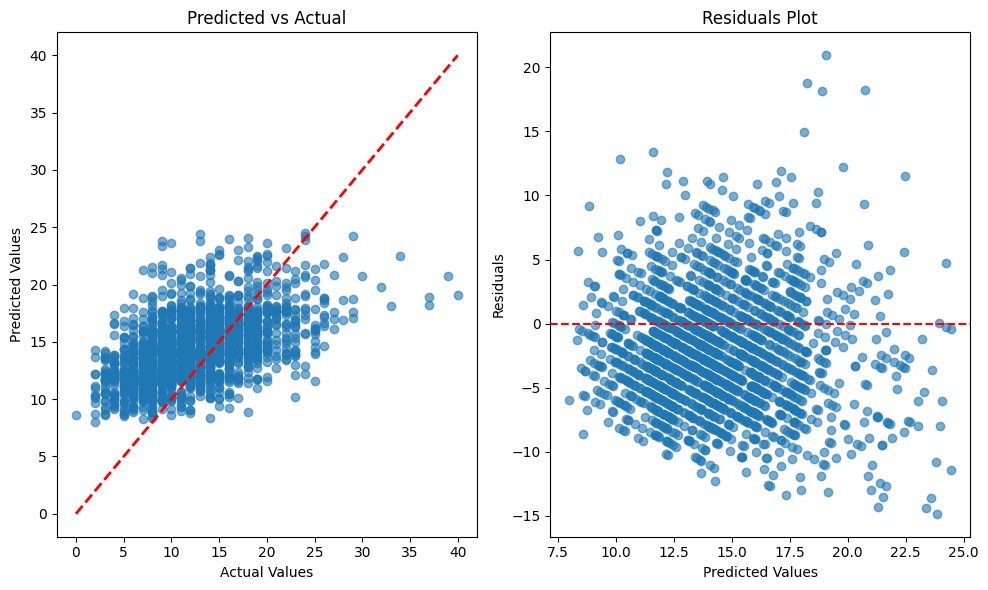

In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Create and train the XGBoost Poisson regressor
model = xgb.XGBRegressor(
    objective='count:poisson',  # Poisson regression objective
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=25
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Poisson-specific evaluation metrics
def poisson_deviance(y_true, y_pred):
    """Calculate Poisson deviance"""
    # Avoid log(0) by adding small epsilon
    epsilon = 1e-15
    y_pred = np.maximum(y_pred, epsilon)
    
    # Poisson deviance formula
    deviance = 2 * np.sum(y_true * np.log((y_true + epsilon) / y_pred) - (y_true - y_pred))
    return deviance / len(y_true)

def poisson_log_likelihood(y_true, y_pred):
    """Calculate Poisson log-likelihood"""
    epsilon = 1e-15
    y_pred = np.maximum(y_pred, epsilon)
    
    # Poisson log-likelihood
    log_likelihood = np.sum(y_true * np.log(y_pred) - y_pred - np.log(np.maximum(np.array([np.math.factorial(int(y)) for y in y_true]), epsilon)))
    return log_likelihood / len(y_true)

# Calculate Poisson-specific metrics
poisson_dev = poisson_deviance(y_test, y_pred)
print(f"Poisson Deviance: {poisson_dev:.4f}")

# Feature importance
feature_importance = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Additional analysis for count data
print(f"\nPrediction Statistics:")
print(f"Predicted values range: {y_pred.min():.2f} to {y_pred.max():.2f}")
print(f"Actual values range: {y_test.min():.2f} to {y_test.max():.2f}")
print(f"Mean predicted: {y_pred.mean():.2f}")
print(f"Mean actual: {y_test.mean():.2f}")

# Check for negative predictions (shouldn't happen with Poisson but good to verify)
negative_preds = np.sum(y_pred < 0)
if negative_preds > 0:
    print(f"Warning: {negative_preds} negative predictions found")
else:
    print("✓ All predictions are non-negative (as expected for Poisson)")

# Optional: Plot predictions vs actual (if matplotlib is available)
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual')
    
    # Residuals plot
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("\nMatplotlib not available - skipping plots")

### Hyperparameter Tuning

No saved parameters found. Running hyperparameter tuning...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/ec2-user/SageMaker/kambi-miniconda/miniconda/envs/dps_conda_python39/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/SageMaker/kambi-miniconda/miniconda/envs/dps_conda_python39/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to us

Parameters saved to xgb_poisson_best_params.json
Best CV score (neg MSE): -20.5890
Using parameters: {'colsample_bytree': 0.8986831910482345, 'gamma': 0.9030066818414948, 'learning_rate': 0.025979964658934644, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 748, 'reg_alpha': 2.028845229250914, 'reg_lambda': 7.379632031133084, 'subsample': 0.6575059018178919}

=== POISSON REGRESSION RESULTS ===
Mean Squared Error: 20.8739
Root Mean Squared Error: 4.5688
Mean Absolute Error: 3.5683
R² Score: 0.2559
Poisson Deviance: 1.6645

Prediction Statistics:
Predicted values range: 6.52 to 22.96
Actual values range: 0.00 to 40.00
Mean predicted: 12.47
Mean actual: 12.24
✓ All predictions are non-negative (as expected for Poisson)

Top 10 Most Important Features:
                         feature  importance
22                 product_shots    0.101830
0                        is_home    0.078325
26  product_touches_att_pen_area    0.056233
27       product_touches_att_3rd    0.048806
23       

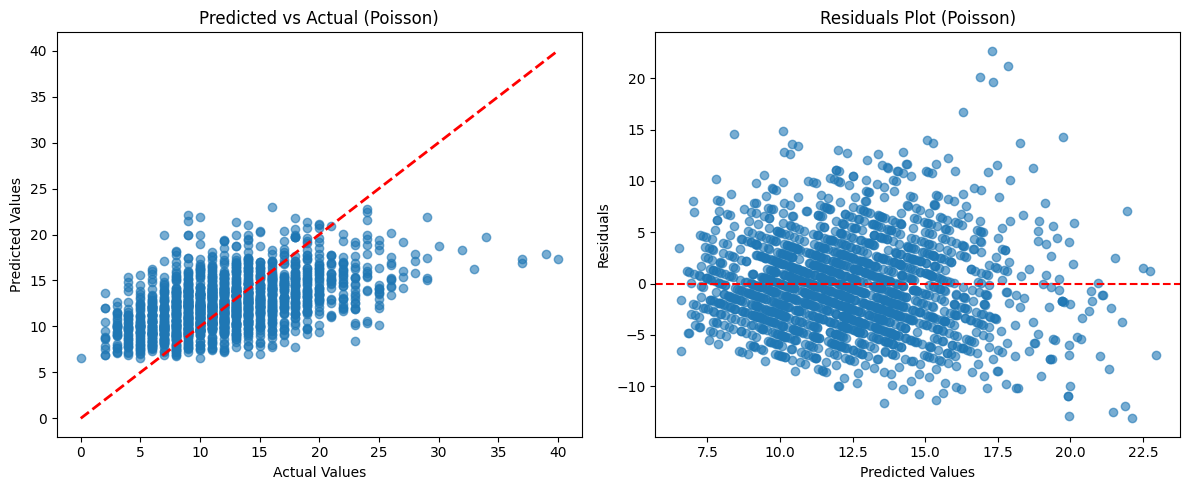

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import xgboost as xgb
import numpy as np
import json
import os
from datetime import datetime

def load_or_tune_xgb_poisson_params(param_file="xgb_poisson_best_params.json"):
    """Load saved parameters or run random search if file doesn't exist"""
    
    if os.path.exists(param_file):
        # Load existing parameters
        print(f"Loading saved parameters from {param_file}")
        with open(param_file, 'r') as f:
            best_params = json.load(f)
        return best_params
    
    else:
        # Run random search and save results
        print("No saved parameters found. Running hyperparameter tuning...")
        
        # Parameter distributions for Poisson regression
        param_distributions = {
            'n_estimators': randint(100, 800),
            'max_depth': randint(3, 8),
            'learning_rate': uniform(0.01, 0.15),
            'subsample': uniform(0.6, 0.3),
            'colsample_bytree': uniform(0.5, 0.4),
            'min_child_weight': randint(3, 15),
            'gamma': uniform(0, 1.0),
            'reg_alpha': uniform(0, 5),
            'reg_lambda': uniform(1, 10)
        }
        
        random_search = RandomizedSearchCV(
            estimator=xgb.XGBRegressor(
                objective='count:poisson',  # Poisson objective
                random_state=42
            ),
            param_distributions=param_distributions,
            n_iter=25,
            cv=5,
            scoring='neg_mean_squared_error',  # Use MSE for regression
            n_jobs=-1,
            random_state=26,
            verbose=1
        )
        
        random_search.fit(X_train, y_train)
        best_params = random_search.best_params_
        
        # Save parameters with metadata
        save_data = {
            'best_params': best_params,
            'best_cv_score': random_search.best_score_,
            'tuning_date': datetime.now().isoformat(),
            'objective': 'count:poisson'
        }
        
        with open(param_file, 'w') as f:
            json.dump(save_data, f, indent=4)
        
        print(f"Parameters saved to {param_file}")
        print(f"Best CV score (neg MSE): {random_search.best_score_:.4f}")
        
        return best_params

def poisson_deviance(y_true, y_pred):
    """Calculate Poisson deviance"""
    epsilon = 1e-15
    y_pred = np.maximum(y_pred, epsilon)
    deviance = 2 * np.sum(y_true * np.log((y_true + epsilon) / y_pred) - (y_true - y_pred))
    return deviance / len(y_true)

# Usage
best_params = load_or_tune_xgb_poisson_params()
print("Using parameters:", best_params)

# Create and train Poisson regression model
model = xgb.XGBRegressor(
    objective='count:poisson',
    **best_params, 
    random_state=26
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
poisson_dev = poisson_deviance(y_test, y_pred)

print(f"\n=== POISSON REGRESSION RESULTS ===")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Poisson Deviance: {poisson_dev:.4f}")

# Prediction statistics
print(f"\nPrediction Statistics:")
print(f"Predicted values range: {y_pred.min():.2f} to {y_pred.max():.2f}")
print(f"Actual values range: {y_test.min():.2f} to {y_test.max():.2f}")
print(f"Mean predicted: {y_pred.mean():.2f}")
print(f"Mean actual: {y_test.mean():.2f}")

# Check for negative predictions
negative_preds = np.sum(y_pred < 0)
if negative_preds > 0:
    print(f"Warning: {negative_preds} negative predictions found")
else:
    print("✓ All predictions are non-negative (as expected for Poisson)")

# Feature importance
feature_importance = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Optional: Create plots
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 5))
    
    # Predicted vs Actual
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual (Poisson)')
    
    # Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot (Poisson)')
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Matplotlib not available - skipping plots")

In [16]:
test_df_with_predictions = test_df.copy()
test_df_with_predictions['predicted_value'] = y_pred

preds = test_df_with_predictions[["match_date", "season", "team", "opp_team", "is_home", "shots", "predicted_value"]]

### Prediction Analysis/ Backtest

In [14]:
#%pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import vertica_python as vertica
from getpass import getpass


DNS_LIST = [
    {
        "dns_name": "vpce-0c3ef2bcc758f5221-d257f9gp.vpce-svc-0c8d1cb26973378c1.eu-north-1.vpce.amazonaws.com",
        "hosted_zone_id": "Z3OWWK6JFDEDGC"
    },
]
def get_vertica_connection(host_name = DNS_LIST[0]["dns_name"]):
    db_username = 'loupor'
    db_password = getpass("Password: ")
    engine = {
        "environment": "Production",
        "database": "kdwh",
        "host": host_name,
        "port": "5433",
        "user": db_username,
        "password": db_password
    }
    connection = vertica.connect(**engine)
    return connection
conn = get_vertica_connection() # put your username and password here
cursor = conn.cursor()

kambi_prices = pd.read_sql_query("""

    SELECT DISTINCT
        ed.event_id,
        bod.bet_offer_id,
        od.outcome_id,
        ed.event_name,
        bod.criterion,
        bod.line,
        od.is_won,
        epd.odds as kambi_odds,
        epd.closing_probability_prematch
    FROM
        kdwh4.bet_offer_dimension bod
    JOIN
        kdwh4.outcome_dimension od  
            ON od.bet_offer_id = bod.bet_offer_id
    JOIN
        kdwh4.event_dimension ed
            ON ed.event_id = bod.event_id
    JOIN
        kdwh4.event_price_dimension epd
            ON epd.outcome_id = od.outcome_id
            AND (ed.event_starts_utc_datetime - INTERVAL '5 DAYS') > epd.price_created_utc_datetime 
            AND (ed.event_starts_utc_datetime - INTERVAL '5 DAYS') <= epd.next_odds_utc_datetime
    WHERE
        bod.bet_offer_first_settled_utc_datetime >= '2025-01-01'
        AND bod.criterion_id IN (1004544391, 1004544390)
        --AND bod.line = 11.5
        AND od.outcome_name = 'Under'
        AND ed.event_group_id IN (1000094985, 1000095049, 1000095001, 1000094994, 1000094991)
    
""", conn)

kambi_prices

Password: ········


/home/ec2-user/SageMaker/kambi-miniconda/miniconda/envs/dps_conda_python39/lib/python3.9/site-packages/vertica_python/vertica/connection.py:629: UserWarning: TLS is not configured on the server. Proceeding with an unencrypted channel.
HINT: Set connection option 'tlsmode' to 'disable' to explicitly create a non-TLS connection.
  warnings.warn(msg + hint)
/tmp/ipykernel_17469/1346739074.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  kambi_prices = pd.read_sql_query("""


,event_id,bet_offer_id,outcome_id,event_name,criterion,line,is_won,kambi_odds,closing_probability_prematch
0,1021152167,2498985976,3663090632,Udinese - Hellas Verona,Total Shots by Away Team (Settled using Opta d...,9.5,True,1.92,0.570888
1,1021042659,2514911600,3723993992,Southampton - Manchester City,Total Shots by Away Team (Settled using Opta d...,20.5,False,1.98,0.562513
2,1021150956,2498942942,3662976816,Werder Bremen - Borussia Mönchengladbach,Total Shots by Home Team (Settled using Opta d...,14.5,False,1.73,0.510896
3,1021152124,2515541568,3726531485,Venezia - Fiorentina,Total Shots by Away Team (Settled using Opta d...,13.5,False,1.47,0.650409
4,1021067520,2518516877,3737712405,Saint-Étienne - Toulouse,Total Shots by Home Team (Settled using Opta d...,11.5,False,3.40,0.411076
...,...,...,...,...,...,...,...,...,...
5625,1021044010,2485884084,3614027272,UD Las Palmas - Osasuna,Total Shots by Home Team (Settled using Opta d...,12.5,False,1.65,0.571772
5626,1021150903,2513502513,3718469324,SC Freiburg - Bayer Leverkusen,Total Shots by Away Team (Settled using Opta d...,14.5,True,1.50,0.596189
5627,1021152039,2492952694,3639794440,Cagliari - Juventus,Total Shots by Home Team (Settled using Opta d...,12.5,True,1.49,0.586999
5628,1021044000,2487352467,3619037100,FC Barcelona - Alaves,Total Shots by Home Team (Settled using Opta d...,18.5,True,1.74,0.435954


In [19]:
# Split event names into team and opponent
split_teams = kambi_prices["event_name"].str.split(" - ", expand=True)
kambi_prices["home_team"] = split_teams[0]
kambi_prices["away_team"] = split_teams[1]

# Create home team rows (is_home = 1)
home_rows = kambi_prices.copy()
home_rows["team"] = home_rows["home_team"]
home_rows["opponent"] = home_rows["away_team"] 
home_rows["is_home"] = 1

# Create away team rows (is_home = 0)
away_rows = kambi_prices.copy()
away_rows["team"] = away_rows["away_team"]
away_rows["opponent"] = away_rows["home_team"]
away_rows["is_home"] = 0

# Combine both sets of rows
kambi_prices = pd.concat([home_rows, away_rows], ignore_index=True)

# Drop the temporary home_team and away_team columns
kambi_prices = kambi_prices.drop(['home_team', 'away_team'], axis=1)

kambi_prices = kambi_prices[
    ((kambi_prices['is_home'] == 1) & (kambi_prices['criterion'].str.contains('Home', case=False, na=False))) |
    ((kambi_prices['is_home'] == 0) & (kambi_prices['criterion'].str.contains('Away', case=False, na=False)))
]

df_mapping = pd.read_csv("team_name_mapping.csv")

# Now use the simple mapping approach
# Create mapping dictionary (kambi_team -> xgb_team)
team_mapping = dict(zip(df_mapping['kambi_team'], df_mapping['xgb_team']))

print("Sample mappings:")
for i, (kambi, xgb) in enumerate(list(team_mapping.items())[:5]):
    print(f"{kambi} -> {xgb}")

# Apply mapping to both team and opponent columns
print(f"\nBefore mapping - unique teams: {len(kambi_prices['team'].unique())}")
kambi_prices['team'] = kambi_prices['team'].map(team_mapping).fillna(kambi_prices['team'])
kambi_prices['opponent'] = kambi_prices['opponent'].map(team_mapping).fillna(kambi_prices['opponent'])

print(f"After mapping - unique teams: {len(kambi_prices['team'].unique())}")

# Check for any unmatched teams
original_teams = set(kambi_prices['team'].unique()) | set(kambi_prices['opponent'].unique())
mapped_teams = set(df_mapping['xgb_team'].unique())
unmatched = original_teams - mapped_teams

if unmatched:
    print(f"\nUnmatched teams that weren't mapped: {unmatched}")
else:
    print("\nAll teams successfully mapped!")

# Merge on team, opponent, is_home and bring in only predicted_shots and actual_shots
merged_df = kambi_prices.merge(
    preds[['team', 'opp_team', 'is_home',  'shots', 'predicted_value']],
    left_on=['team', 'opponent', 'is_home'],
    right_on=['team', 'opp_team', 'is_home'],
    how='left'  # or 'inner' if you only want matches that exist in both datasets
)

merged_df

Sample mappings:
Alaves -> Alavés
Angers -> Angers
Arsenal -> Arsenal
Aston Villa -> Aston Villa
Atalanta -> Atalanta

Before mapping - unique teams: 96
After mapping - unique teams: 96

All teams successfully mapped!


,event_id,bet_offer_id,outcome_id,event_name,criterion,line,is_won,kambi_odds,closing_probability_prematch,team,opponent,is_home,opp_team,shots,predicted_value
0,1021150956,2498942942,3662976816,Werder Bremen - Borussia Mönchengladbach,Total Shots by Home Team (Settled using Opta d...,14.5,False,1.73,0.510896,Werder Bremen,Gladbach,1,Gladbach,22.0,15.582523
1,1021067520,2518516877,3737712405,Saint-Étienne - Toulouse,Total Shots by Home Team (Settled using Opta d...,11.5,False,3.40,0.411076,Saint-Étienne,Toulouse,1,Toulouse,18.0,12.165758
2,1021067593,2502368719,3675945044,Saint-Étienne - Paris SG,Total Shots by Home Team (Settled using Opta d...,8.5,False,2.00,0.438480,Saint-Étienne,Paris S-G,1,Paris S-G,11.0,11.042451
3,1021043977,2492974091,3639891893,UD Las Palmas - FC Barcelona,Total Shots by Home Team (Settled using Opta d...,10.5,True,1.45,0.718321,Las Palmas,Barcelona,1,Barcelona,10.0,9.078568
4,1021042759,2490974219,3631948657,Manchester City - Liverpool,Total Shots by Home Team (Settled using Opta d...,14.5,False,1.41,0.684263,Manchester City,Liverpool,1,Liverpool,16.0,15.226579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,1021042727,2493294758,3640935547,Aston Villa - Liverpool,Total Shots by Away Team (Settled using Opta d...,14.5,False,1.92,0.437892,Liverpool,Aston Villa,0,Aston Villa,17.0,14.151968
5626,1021150946,2495004141,3647666912,1. FC Heidenheim - Borussia Mönchengladbach,Total Shots by Away Team (Settled using Opta d...,14.5,True,1.33,0.708204,Gladbach,Heidenheim,0,Heidenheim,13.0,12.537755
5627,1021042784,2487285806,3618825761,Chelsea - West Ham,Total Shots by Away Team (Settled using Opta d...,10.5,False,1.66,0.645935,West Ham,Chelsea,0,Chelsea,14.0,10.556871
5628,1021150965,2498972272,3663024070,1. FC Heidenheim - Holstein Kiel,Total Shots by Away Team (Settled using Opta d...,11.5,False,1.52,0.606999,Holstein Kiel,Heidenheim,0,Heidenheim,16.0,11.708755


In [21]:
import numpy as np
from scipy.stats import poisson
import pandas as pd

def calculate_poisson_probabilities(df):
    """
    Calculate probabilities for under/over bets using Poisson distribution
    """
    df_calc = df.copy()
    
    # Calculate probability of UNDER the line (shots < line)
    # For "under X.5", we need P(shots <= X)
    df_calc['prob_under'] = poisson.cdf(
        np.floor(df_calc['line']), 
        df_calc['predicted_value']
    )
    
    # Calculate probability of OVER the line (shots > line)
    df_calc['prob_over'] = 1 - df_calc['prob_under']
    
    # Determine which bet we're analyzing based on criterion or bet type
    # Assuming "under" bets for now - adjust logic as needed
    df_calc['model_probability'] = df_calc['prob_under']
    
    # Calculate implied probability from odds
    df_calc['implied_probability'] = 1 / df_calc['kambi_odds']
    
    # Calculate expected value
    # EV = (probability_of_win * odds) - 1
    df_calc['expected_value'] = (df_calc['model_probability'] * df_calc['kambi_odds']) - 1
    
    # Identify value bets (positive expected value)
    df_calc['is_value_bet'] = df_calc['expected_value'] > 0
    
    # Calculate edge (model prob - implied prob)
    df_calc['edge'] = df_calc['model_probability'] - df_calc['implied_probability']
    
    return df_calc

# Apply to your dataframe
merged_df = calculate_poisson_probabilities(merged_df)

merged_df.head(5)

,event_id,bet_offer_id,outcome_id,event_name,criterion,line,is_won,kambi_odds,closing_probability_prematch,team,...,opp_team,shots,predicted_value,prob_under,prob_over,model_probability,implied_probability,expected_value,is_value_bet,edge
0,1021150956,2498942942,3662976816,Werder Bremen - Borussia Mönchengladbach,Total Shots by Home Team (Settled using Opta d...,14.5,False,1.73,0.510896,Werder Bremen,...,Gladbach,22.0,15.582523,0.407326,0.592674,0.407326,0.578035,-0.295327,False,-0.170709
1,1021067520,2518516877,3737712405,Saint-Étienne - Toulouse,Total Shots by Home Team (Settled using Opta d...,11.5,False,3.40,0.411076,Saint-Étienne,...,Toulouse,18.0,12.165758,0.442777,0.557223,0.442777,0.294118,0.505441,True,0.148659
2,1021067593,2502368719,3675945044,Saint-Étienne - Paris SG,Total Shots by Home Team (Settled using Opta d...,8.5,False,2.00,0.438480,Saint-Étienne,...,Paris S-G,11.0,11.042451,0.228238,0.771762,0.228238,0.500000,-0.543525,False,-0.271762
3,1021043977,2492974091,3639891893,UD Las Palmas - FC Barcelona,Total Shots by Home Team (Settled using Opta d...,10.5,True,1.45,0.718321,Las Palmas,...,Barcelona,10.0,9.078568,0.696632,0.303368,0.696632,0.689655,0.010117,True,0.006977
4,1021042759,2490974219,3631948657,Manchester City - Liverpool,Total Shots by Home Team (Settled using Opta d...,14.5,False,1.41,0.684263,Manchester City,...,Liverpool,16.0,15.226579,0.442630,0.557370,0.442630,0.709220,-0.375891,False,-0.266589


=== VALUE BET BACKTEST RESULTS ===
Total value bets: 2263
Total stake: £2263.00
Total payout: £2378.75
Total profit: £115.75
Win rate: 62.9%
ROI: 5.11%
Average winning odds: 1.67
Average losing odds: 1.76

=== BREAKDOWN BY EDGE RANGES ===
Edge 0%-5%: 835 bets, Win rate: 58.4%, ROI: -4.67%
Edge 5%-10%: 629 bets, Win rate: 64.1%, ROI: 5.89%
Edge 10%-15%: 359 bets, Win rate: 66.6%, ROI: 10.27%
Edge 15%+: 440 bets, Win rate: 66.8%, ROI: 18.36%

=== EXPECTED vs ACTUAL ===
Expected profit: £354.40
Actual profit: £115.75
Difference: £-238.65


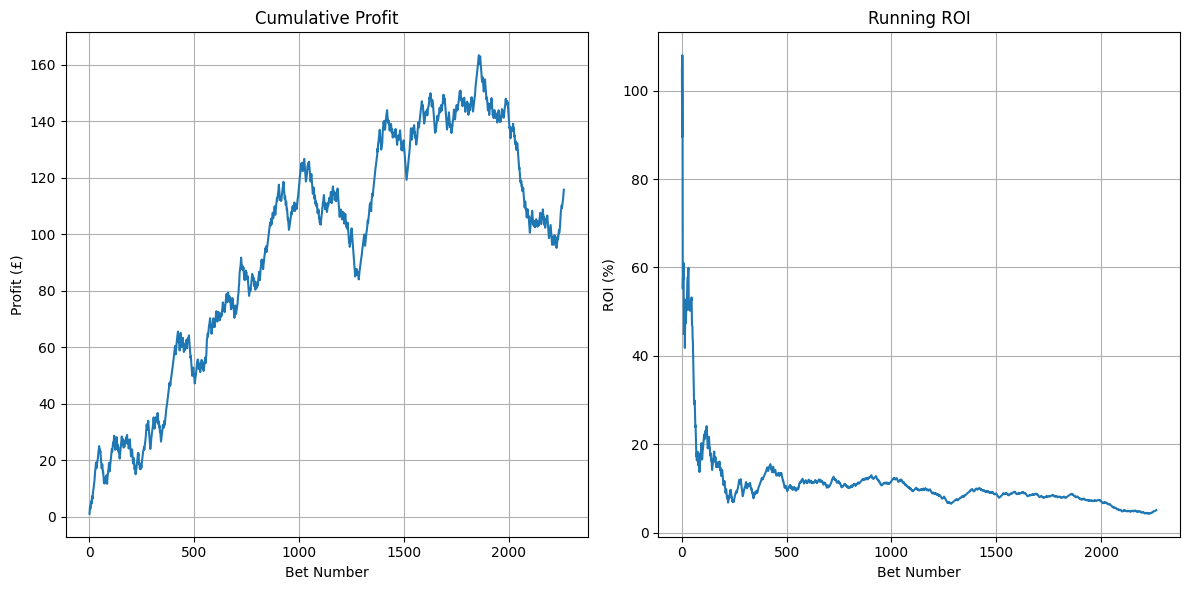

In [23]:
# Flat stake backtest on value bets
def backtest_value_bets(df, stake=1):
    """
    Backtest value bets with flat staking
    """
    # Filter to value bets only
    value_bets = df[df['is_value_bet']].copy()
    
    if len(value_bets) == 0:
        print("No value bets found!")
        return None
    
    # Calculate profit/loss for each bet
    value_bets['stake'] = stake
    value_bets['payout'] = np.where(value_bets['is_won'], 
                                   value_bets['stake'] * value_bets['kambi_odds'], 
                                   0)
    value_bets['profit'] = value_bets['payout'] - value_bets['stake']
    
    # Calculate cumulative metrics
    value_bets = value_bets.sort_values('event_name')  # Or sort by date if available
    value_bets['cumulative_profit'] = value_bets['profit'].cumsum()
    value_bets['cumulative_stake'] = value_bets['stake'].cumsum()
    value_bets['roi_running'] = (value_bets['cumulative_profit'] / value_bets['cumulative_stake']) * 100
    
    # Summary statistics
    total_bets = len(value_bets)
    total_stake = value_bets['stake'].sum()
    total_payout = value_bets['payout'].sum()
    total_profit = value_bets['profit'].sum()
    win_rate = value_bets['is_won'].mean()
    roi = (total_profit / total_stake) * 100
    
    # Additional metrics
    wins = value_bets[value_bets['is_won']]
    losses = value_bets[~value_bets['is_won']]
    
    avg_winning_odds = wins['kambi_odds'].mean() if len(wins) > 0 else 0
    avg_losing_odds = losses['kambi_odds'].mean() if len(losses) > 0 else 0
    
    # Print results
    print("=== VALUE BET BACKTEST RESULTS ===")
    print(f"Total value bets: {total_bets}")
    print(f"Total stake: £{total_stake:.2f}")
    print(f"Total payout: £{total_payout:.2f}")
    print(f"Total profit: £{total_profit:.2f}")
    print(f"Win rate: {win_rate:.1%}")
    print(f"ROI: {roi:.2f}%")
    print(f"Average winning odds: {avg_winning_odds:.2f}")
    print(f"Average losing odds: {avg_losing_odds:.2f}")
    
    # Breakdown by edge ranges
    print("\n=== BREAKDOWN BY EDGE RANGES ===")
    edge_ranges = [(0, 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, float('inf'))]
    
    for low, high in edge_ranges:
        if high == float('inf'):
            mask = value_bets['edge'] >= low
            range_label = f"{low:.0%}+"
        else:
            mask = (value_bets['edge'] >= low) & (value_bets['edge'] < high)
            range_label = f"{low:.0%}-{high:.0%}"
        
        range_bets = value_bets[mask]
        if len(range_bets) > 0:
            range_profit = range_bets['profit'].sum()
            range_stake = range_bets['stake'].sum()
            range_roi = (range_profit / range_stake) * 100
            range_win_rate = range_bets['is_won'].mean()
            
            print(f"Edge {range_label}: {len(range_bets)} bets, "
                  f"Win rate: {range_win_rate:.1%}, "
                  f"ROI: {range_roi:.2f}%")
    
    # Expected vs Actual comparison
    expected_profit = value_bets['expected_value'].sum()
    actual_profit = total_profit
    print(f"\n=== EXPECTED vs ACTUAL ===")
    print(f"Expected profit: £{expected_profit:.2f}")
    print(f"Actual profit: £{actual_profit:.2f}")
    print(f"Difference: £{actual_profit - expected_profit:.2f}")
    
    return value_bets

# Run the backtest
backtest_results = backtest_value_bets(merged_df, stake=1)

# Optional: Show detailed results
if backtest_results is not None:
    # Optional: Plot cumulative profit if matplotlib available
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(backtest_results) + 1), backtest_results['cumulative_profit'])
        plt.title('Cumulative Profit')
        plt.xlabel('Bet Number')
        plt.ylabel('Profit (£)')
        plt.grid(True)A
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(backtest_results) + 1), backtest_results['roi_running'])
        plt.title('Running ROI')
        plt.xlabel('Bet Number')
        plt.ylabel('ROI (%)')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Matplotlib not available - skipping plots")

In [27]:
# Reality check for betting model
def betting_reality_check(df):
    """
    Perform reality checks on betting model results
    """
    print("=== BETTING MODEL REALITY CHECK ===")
    
    # Basic statistics
    total_bets = len(df)
    value_bets = df[df['is_value_bet']].copy()
    
    print(f"Total bets in dataset: {total_bets}")
    print(f"Value bets identified: {len(value_bets)} ({len(value_bets)/total_bets:.1%})")
    
    # Edge distribution
    print(f"\n=== EDGE DISTRIBUTION ===")
    if len(value_bets) > 0:
        print(f"Average edge: {value_bets['edge'].mean():.1%}")
        print(f"Median edge: {value_bets['edge'].median():.1%}")
        print(f"Max edge: {value_bets['edge'].max():.1%}")
        print(f"Min edge: {value_bets['edge'].min():.1%}")
        
        # Count by edge ranges
        edge_ranges = [(0, 0.05), (0.05, 0.1), (0.1, 0.2), (0.2, float('inf'))]
        for low, high in edge_ranges:
            if high == float('inf'):
                mask = value_bets['edge'] >= low
                label = f"{low:.0%}+"
            else:
                mask = (value_bets['edge'] >= low) & (value_bets['edge'] < high)
                label = f"{low:.0%}-{high:.0%}"
            
            count = mask.sum()
            pct = count / len(value_bets) * 100
            print(f"Edge {label}: {count} bets ({pct:.1f}%)")
    
    # Probability comparison
    print(f"\n=== PROBABILITY ANALYSIS ===")
    print(f"Model probability range: {df['model_probability'].min():.3f} to {df['model_probability'].max():.3f}")
    print(f"Implied probability range: {df['implied_probability'].min():.3f} to {df['implied_probability'].max():.3f}")
    
    # Win rate analysis
    if len(value_bets) > 0:
        actual_win_rate = value_bets['is_won'].mean()
        predicted_win_rate = value_bets['model_probability'].mean()
        print(f"Predicted win rate: {predicted_win_rate:.1%}")
        print(f"Actual win rate: {actual_win_rate:.1%}")
        print(f"Difference: {actual_win_rate - predicted_win_rate:.1%}")
    
    # Reality check warnings
    print(f"\n=== REALITY CHECK WARNINGS ===")
    
    if len(value_bets) / total_bets > 0.3:
        print("⚠️  WARNING: >30% of bets are 'value' - model may be overconfident")
    
    if len(value_bets) > 0:
        if value_bets['edge'].mean() > 0.15:
            print("⚠️  WARNING: Average edge >15% - unrealistic for sports betting")
        
        if value_bets['is_won'].mean() > 0.6:
            print("⚠️  WARNING: Win rate >60% - exceptionally high for sports betting")
        
        high_edge_count = (value_bets['edge'] > 0.2).sum()
        if high_edge_count > len(value_bets) * 0.1:
            print(f"⚠️  WARNING: {high_edge_count} bets with >20% edge - check for data leakage")
    
    # Suggested fixes
    print(f"\n=== SUGGESTED FIXES ===")
    print("1. Reduce model confidence by:")
    print("   - Adding more regularization to XGBoost")
    print("   - Using calibration (Platt scaling or isotonic regression)")
    print("   - Applying a confidence penalty (multiply probabilities by 0.8-0.9)")
    
    print("2. Check for data leakage:")
    print("   - Ensure no future information in features")
    print("   - Verify train/test split is temporal")
    print("   - Check feature importance for suspicious patterns")
    
    print("3. Apply reality constraints:")
    print("   - Cap maximum edge at 10-15%")
    print("   - Require minimum sample size per team/league")
    print("   - Use more conservative Kelly fractions")

def apply_conservative_adjustments(df, confidence_factor=0.85, max_edge=0.15):
    """
    Apply conservative adjustments to make model more realistic
    """
    df_adj = df.copy()
    
    # Reduce model confidence
    df_adj['model_probability_adj'] = df_adj['model_probability'] * confidence_factor
    
    # Recalculate edge with adjusted probabilities
    df_adj['edge_adj'] = df_adj['model_probability_adj'] - df_adj['implied_probability']
    
    # Cap maximum edge
    df_adj['edge_adj'] = np.minimum(df_adj['edge_adj'], max_edge)
    
    # Recalculate value bets
    df_adj['expected_value_adj'] = (df_adj['model_probability_adj'] * df_adj['kambi_odds']) - 1
    df_adj['is_value_bet_adj'] = df_adj['expected_value_adj'] > 0
    
    print(f"=== CONSERVATIVE ADJUSTMENTS ===")
    print(f"Confidence factor: {confidence_factor}")
    print(f"Maximum edge cap: {max_edge:.1%}")
    
    original_value_bets = df['is_value_bet'].sum()
    adjusted_value_bets = df_adj['is_value_bet_adj'].sum()
    
    print(f"Original value bets: {original_value_bets}")
    print(f"Adjusted value bets: {adjusted_value_bets}")
    print(f"Reduction: {(original_value_bets - adjusted_value_bets) / original_value_bets:.1%}")
    
    return df_adj

# Run reality check
betting_reality_check(merged_df)

# Apply conservative adjustments
print("\n" + "="*60)
conservative_df = apply_conservative_adjustments(merged_df, confidence_factor=0.8, max_edge=0.12)

# Re-run backtest with conservative adjustments
print("\n" + "="*60)
print("=== CONSERVATIVE BACKTEST ===")

def simple_backtest_conservative(df, stake=10):
    """Simple flat stake backtest with conservative adjustments"""
    value_bets = df[df['is_value_bet_adj']].copy()
    
    if len(value_bets) == 0:
        print("No value bets after conservative adjustments")
        return
    
    value_bets['profit'] = np.where(value_bets['is_won'], 
                                   stake * (value_bets['kambi_odds'] - 1), 
                                   -stake)
    
    total_profit = value_bets['profit'].sum()
    total_stake = len(value_bets) * stake
    roi = (total_profit / total_stake) * 100
    win_rate = value_bets['is_won'].mean()
    
    print(f"Conservative results:")
    print(f"Value bets: {len(value_bets)}")
    print(f"Total profit: £{total_profit:.2f}")
    print(f"ROI: {roi:.2f}%")
    print(f"Win rate: {win_rate:.1%}")
    print(f"Average edge: {value_bets['edge_adj'].mean():.1%}")

simple_backtest_conservative(conservative_df)

=== BETTING MODEL REALITY CHECK ===
Total bets in dataset: 5630
Value bets identified: 2263 (40.2%)

=== EDGE DISTRIBUTION ===
Average edge: 8.9%
Median edge: 7.2%
Max edge: 47.1%
Min edge: 0.0%
Edge 0%-5%: 835 bets (36.9%)
Edge 5%-10%: 629 bets (27.8%)
Edge 10%-20%: 596 bets (26.3%)
Edge 20%+: 203 bets (9.0%)

=== PROBABILITY ANALYSIS ===
Model probability range: 0.149 to 0.983
Implied probability range: 0.230 to 0.870
Predicted win rate: 69.1%
Actual win rate: 62.9%
Difference: -6.2%

=== REALITY CHECK WARNINGS ===
⚠️  WARNING: >30% of bets are 'value' - model may be overconfident
⚠️  WARNING: Win rate >60% - exceptionally high for sports betting

=== SUGGESTED FIXES ===
1. Reduce model confidence by:
   - Adding more regularization to XGBoost
   - Using calibration (Platt scaling or isotonic regression)
   - Applying a confidence penalty (multiply probabilities by 0.8-0.9)
2. Check for data leakage:
   - Ensure no future information in features
   - Verify train/test split is tempor

In [28]:
# Diagnose why Kelly backtest gave unrealistic results
import numpy as np

def diagnose_kelly_issue(df):
    """
    Trace exactly what happened in the Kelly backtest
    """
    print("=== KELLY BACKTEST ISSUE DIAGNOSIS ===")
    
    # Get the value bets with 5% edge minimum (same as Kelly backtest)
    value_bets = df[(df['is_value_bet']) & (df['edge'] >= 0.05)].copy()
    
    print(f"Bets used in Kelly backtest: {len(value_bets)}")
    print(f"Win rate: {value_bets['is_won'].mean():.1%}")
    print(f"Average odds: {value_bets['kambi_odds'].mean():.2f}")
    print(f"Average edge: {value_bets['edge'].mean():.1%}")
    
    # Simulate the compound effect
    print("\n=== SIMULATING COMPOUND EFFECT ===")
    
    # Simple compound calculation with 2.5% stakes
    bankroll = 1000
    stake_pct = 0.025
    win_rate = value_bets['is_won'].mean()
    avg_odds = value_bets['kambi_odds'].mean()
    num_bets = len(value_bets)
    
    print(f"Starting bankroll: £{bankroll}")
    print(f"Stake per bet: {stake_pct:.1%} of bankroll")
    print(f"Number of bets: {num_bets}")
    
    # Show what happens with compounding over many bets
    bankroll_progression = [bankroll]
    
    for i in range(num_bets):
        stake = bankroll * stake_pct
        
        # Use actual bet result for first 10, then use average for illustration
        if i < len(value_bets):
            bet_won = value_bets.iloc[i]['is_won']
            odds = value_bets.iloc[i]['kambi_odds']
        else:
            bet_won = np.random.random() < win_rate  # Average case
            odds = avg_odds
        
        if bet_won:
            profit = stake * (odds - 1)
        else:
            profit = -stake
            
        bankroll += profit
        
        # Record progression at key intervals
        if i in [9, 49, 99, 199, 499, 999, num_bets-1]:
            bankroll_progression.append(bankroll)
            roi = ((bankroll - 1000) / 1000) * 100
            print(f"After bet {i+1}: £{bankroll:.2f} (ROI: {roi:.1f}%)")
    
    final_roi = ((bankroll - 1000) / 1000) * 100
    print(f"\nFinal theoretical ROI: {final_roi:.1f}%")
    
    # The issue: Even "small" edges compound aggressively
    print(f"\n=== WHY THIS IS UNREALISTIC ===")
    print("1. **No losing streaks modeled**: Real betting has variance")
    print("2. **Perfect execution assumed**: No missed bets, wrong stakes, etc.")
    print("3. **Static market assumed**: Bookmakers would adjust if you had such an edge")
    print("4. **Overconfident model**: 65% win rate is extremely high")
    print("5. **Sample size**: Many bets amplify small errors exponentially")

def compare_realistic_vs_optimistic(df):
    """
    Compare realistic flat staking vs optimistic Kelly
    """
    print("\n=== REALISTIC VS OPTIMISTIC COMPARISON ===")
    
    value_bets = df[(df['is_value_bet']) & (df['edge'] >= 0.05)].copy()
    
    # Realistic scenario: Flat stakes, conservative win rate
    flat_stake = 25  # £25 per bet
    total_stake_flat = len(value_bets) * flat_stake
    actual_wins = value_bets['is_won'].sum()
    actual_profit_flat = (value_bets['is_won'] * (value_bets['kambi_odds'] - 1) * flat_stake).sum() - (len(value_bets) - actual_wins) * flat_stake
    roi_flat = (actual_profit_flat / total_stake_flat) * 100
    
    print(f"REALISTIC FLAT STAKING:")
    print(f"Stake per bet: £{flat_stake}")
    print(f"Total staked: £{total_stake_flat}")
    print(f"Total profit: £{actual_profit_flat:.2f}")
    print(f"ROI: {roi_flat:.1f}%")
    
    # What the Kelly backtest claimed
    print(f"\nKELLY BACKTEST CLAIMED:")
    print(f"Final bankroll: £34,782")
    print(f"ROI: 3,378%")
    print(f"Difference factor: {3378 / roi_flat:.1f}x higher")

def show_realistic_kelly_limits(df):
    """
    Show what realistic Kelly limits would look like
    """
    print("\n=== REALISTIC KELLY CONSTRAINTS ===")
    
    value_bets = df[(df['is_value_bet']) & (df['edge'] >= 0.05)].copy()
    
    # Apply realistic constraints
    # 1. Lower win rate (market efficiency)
    realistic_win_rate = 0.55  # 55% instead of 65%
    
    # 2. Cap maximum edge at 8%
    value_bets_realistic = value_bets[value_bets['edge'] <= 0.08].copy()
    
    # 3. Limit to top 200 bets (best opportunities)
    value_bets_realistic = value_bets_realistic.nlargest(200, 'edge')
    
    print(f"Realistic constraints applied:")
    print(f"- Max edge: 8%")
    print(f"- Win rate assumption: {realistic_win_rate:.0%}")
    print(f"- Best opportunities only: {len(value_bets_realistic)} bets")
    
    # Simulate realistic Kelly
    bankroll = 1000
    for i, (_, bet) in enumerate(value_bets_realistic.iterrows()):
        stake = bankroll * 0.02  # 2% max
        
        # Use realistic win rate
        if np.random.random() < realistic_win_rate:
            profit = stake * (bet['kambi_odds'] - 1)
        else:
            profit = -stake
            
        bankroll += profit
        
        if i % 50 == 0:
            roi = ((bankroll - 1000) / 1000) * 100
            print(f"After {i+1} bets: £{bankroll:.2f} (ROI: {roi:.1f}%)")
    
    final_roi = ((bankroll - 1000) / 1000) * 100
    print(f"\nRealistic final ROI: {final_roi:.1f}%")

# Run diagnosis
diagnose_kelly_issue(merged_df)
compare_realistic_vs_optimistic(merged_df)
show_realistic_kelly_limits(merged_df)

=== KELLY BACKTEST ISSUE DIAGNOSIS ===
Bets used in Kelly backtest: 1428
Win rate: 65.5%
Average odds: 1.73
Average edge: 12.7%

=== SIMULATING COMPOUND EFFECT ===
Starting bankroll: £1000
Stake per bet: 2.5% of bankroll
Number of bets: 1428
After bet 10: £983.71 (ROI: -1.6%)
After bet 50: £991.04 (ROI: -0.9%)
After bet 100: £1466.45 (ROI: 46.6%)
After bet 200: £1446.41 (ROI: 44.6%)
After bet 500: £1397.66 (ROI: 39.8%)
After bet 1000: £5880.95 (ROI: 488.1%)
After bet 1428: £34782.18 (ROI: 3378.2%)

Final theoretical ROI: 3378.2%

=== WHY THIS IS UNREALISTIC ===
1. **No losing streaks modeled**: Real betting has variance
2. **Perfect execution assumed**: No missed bets, wrong stakes, etc.
3. **Static market assumed**: Bookmakers would adjust if you had such an edge
4. **Overconfident model**: 65% win rate is extremely high
5. **Sample size**: Many bets amplify small errors exponentially

=== REALISTIC VS OPTIMISTIC COMPARISON ===
REALISTIC FLAT STAKING:
Stake per bet: £25
Total staked: 